In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix, classification_report
# import warnings
# warnings.filterwarnings('ignore')

### Packages data path

In [2]:
## set train, validation, and test paths
train_path = '../input/datasetfinal/dataset70-10-20/train/Packages'
validation_path = '../input/datasetfinal/dataset70-10-20/val/Packages'
test_path = '../input/datasetfinal/dataset70-10-20/test/Packages'

In [3]:
classes=[]
for root, subdirectories, files in os.walk(train_path):
    for subdirectory in subdirectories:
        classes.append(subdirectory)
print(len(classes))
print(classes)

31
['Arla-Sour-Cream', 'Arla-Lactose-Medium-Fat-Milk', 'Alpro-Shelf-Soy-Milk', 'Tropicana-Apple-Juice', 'Arla-Natural-Yoghurt', 'Arla-Natural-Mild-Low-Fat-Yoghurt', 'Bravo-Orange-Juice', 'God-Morgon-Apple-Juice', 'Alpro-Blueberry-Soyghurt', 'God-Morgon-Red-Grapefruit-Juice', 'Oatly-Natural-Oatghurt', 'Alpro-Vanilla-Soyghurt', 'Tropicana-Juice-Smooth', 'Bravo-Apple-Juice', 'Arla-Mild-Vanilla-Yoghurt', 'Tropicana-Mandarin-Morning', 'Yoggi-Vanilla-Yoghurt', 'Yoggi-Strawberry-Yoghurt', 'Arla-Ecological-Medium-Fat-Milk', 'Valio-Vanilla-Yoghurt', 'Arla-Medium-Fat-Milk', 'Garant-Ecological-Medium-Fat-Milk', 'Arla-Standard-Milk', 'Alpro-Fresh-Soy-Milk', 'God-Morgon-Orange-Juice', 'Arla-Ecological-Sour-Cream', 'God-Morgon-Orange-Red-Grapefruit-Juice', 'Arla-Sour-Milk', 'Tropicana-Golden-Grapefruit', 'Oatly-Oat-Milk', 'Garant-Ecological-Standard-Milk']


In [4]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224, 224), classes = classes, batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224, 224), classes = classes, batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224, 224), classes = classes, batch_size = 10)

Found 1218 images belonging to 31 classes.
Found 162 images belonging to 31 classes.
Found 378 images belonging to 31 classes.


## Data Augmentation

In [5]:
## Augmentation datagenerator
train_datagen_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        zoom_range=0.2)

## train generator
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## test generator, required for prediction
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

## validation generator
val_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1218 images belonging to 31 classes.
Found 378 images belonging to 31 classes.
Found 162 images belonging to 31 classes.


In [6]:
## set steps per epoch for train
train_filenames = train_generator_aug.filenames
steps_train = len(train_filenames)/train_generator_aug.batch_size

## set steps per epoch for validation
val_filenames = val_generator.filenames
steps_val = len(val_filenames)/val_generator.batch_size

## test
filenames_test = test_generator.filenames
nb_samples_test= len(filenames_test)
true_classes = test_generator.classes
target_names = classes

## VGG19 with Augmentation and DropOut

In [7]:
base_model_vgg19 = VGG19(weights = 'imagenet',include_top=False, input_shape=(224, 224, 3))  #not include the 3 fully-connected layers at the top of the network.
base_model_vgg19.summary()
#plot_model(base_model_vgg19)

base_model_vgg19.trainable = False

2021-12-29 15:17:02.185969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 15:17:02.282504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 15:17:02.283335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 15:17:02.284575: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
translearn_vgg19 = Sequential()

# Add vgg19 layer by layer to our model and freeze all
for layer in base_model_vgg19.layers:
    translearn_vgg19.add(layer)
    
# train last two layers of vgg19
for layer in translearn_vgg19.layers[-2:]:
    layer.trainable=True
    
translearn_vgg19.add(GlobalAveragePooling2D())
translearn_vgg19.add(Dropout(0.2))
translearn_vgg19.add(Dense(31, activation='softmax'))
translearn_vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [9]:
## compile model
translearn_vgg19.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.002),
              metrics=['acc'])

# Callbacks
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 5, verbose=1)
mc = ModelCheckpoint("./vgg19_best_packages.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
cb=[es, mc]

## fit model
model_vgg19 = translearn_vgg19.fit(train_generator_aug,
                                   steps_per_epoch=steps_train,
                                   epochs=100,
                                   validation_data=val_generator,
                                   validation_steps=steps_val,
                                   verbose=1,
                                   callbacks=cb)

2021-12-29 15:17:07.578247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-29 15:17:10.006033: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 32s 467ms/step - loss: 3.3767 - acc: 0.1305 - val_loss: 2.4824 - val_acc: 0.2840
Epoch 2/100
48/48 [==============================] - 17s 343ms/step - loss: 2.3195 - acc: 0.3621 - val_loss: 1.4176 - val_acc: 0.6543
Epoch 3/100
48/48 [==============================] - 18s 370ms/step - loss: 1.6040 - acc: 0.5279 - val_loss: 1.0086 - val_acc: 0.7160
Epoch 4/100
48/48 [==============================] - 16s 334ms/step - loss: 1.2081 - acc: 0.6453 - val_loss: 0.7743 - val_acc: 0.7407
Epoch 5/100
48/48 [==============================] - 17s 358ms/step - loss: 0.9253 - acc: 0.7151 - val_loss: 0.5404 - val_acc: 0.8210
Epoch 6/100
48/48 [==============================] - 16s 333ms/step - loss: 0.8022 - acc: 0.7545 - val_loss: 0.5033 - val_acc: 0.8210
Epoch 7/100
48/48 [==============================] - 17s 352ms/step - loss: 0.7043 - acc: 0.8054 - val_loss: 0.3670 - val_acc: 0.8827
Epoch 8/100
48/48 [==============================] - 16s 336ms/step - loss

In [10]:
translearn_vgg19.save('packages_vgg19.h5')

In [11]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(translearn_vgg19)
tflite_model = converter.convert()

# Save the model.
with open('packages_vgg19.tflite', 'wb') as f:
    f.write(tflite_model)

2021-12-29 15:46:10.240794: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-29 15:46:12.227717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 15:46:12.228118: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-29 15:46:12.228250: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-29 15:46:12.228719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 15:46:12.229121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

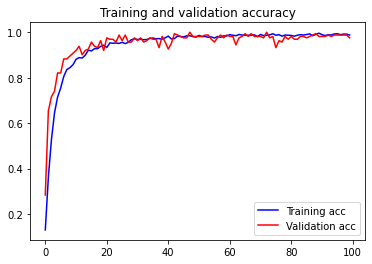

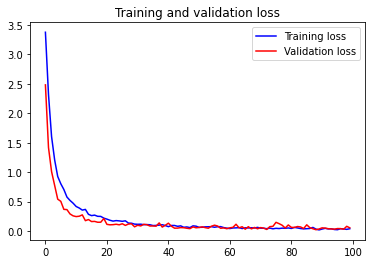

In [12]:
acc = model_vgg19.history['acc']
val_acc = model_vgg19.history['val_acc']
loss = model_vgg19.history['loss']
val_loss = model_vgg19.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Predict

In [13]:
pack_pred= translearn_vgg19.predict(test_generator, steps = nb_samples_test, verbose=2)
pack_pred = pack_pred.argmax(axis=1)

378/378 - 3s


### Confusion Matrix

In [14]:
# cm = confusion_matrix(pack_pred, true_classes)
# f, ax= plt.subplots(1,1,figsize=(15,15))
# sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels') 
# ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(classes) 
# ax.yaxis.set_ticklabels(classes)

### Classification Report

In [15]:
print(classification_report(true_classes, pack_pred, target_names=target_names))

                                        precision    recall  f1-score   support

                       Arla-Sour-Cream       1.00      1.00      1.00        13
          Arla-Lactose-Medium-Fat-Milk       1.00      0.85      0.92        13
                  Alpro-Shelf-Soy-Milk       0.92      1.00      0.96        12
                 Tropicana-Apple-Juice       0.83      0.91      0.87        11
                  Arla-Natural-Yoghurt       1.00      1.00      1.00        13
     Arla-Natural-Mild-Low-Fat-Yoghurt       1.00      0.82      0.90        11
                    Bravo-Orange-Juice       1.00      0.92      0.96        12
                God-Morgon-Apple-Juice       1.00      1.00      1.00        15
              Alpro-Blueberry-Soyghurt       1.00      0.92      0.96        13
       God-Morgon-Red-Grapefruit-Juice       1.00      1.00      1.00        11
                Oatly-Natural-Oatghurt       1.00      1.00      1.00        19
                Alpro-Vanilla-Soyghurt 